# Linear Regression from Scratch in PyTorch


Linear Regression is a foundational tool in the field of machine learning and statistics, used for predicting a continuous target variable based on one or more predictor variables. This guide delves into implementing linear regression in PyTorch, a leading deep learning library.

## Theoretical Background

Linear regression models the relationship between a dependent variable, `y`, and one or more independent variables, `X`, as a linear function:

$ y = Xw + b + \epsilon $

- $X$ represents the independent variables (features).
- $w$ is a weight matrix corresponding to the coefficients of the features.
- $b$ is the bias term, an intercept in the linear equation.
- $\epsilon$ is the error term, capturing the deviation of the predictions from the actual values.

The goal of linear regression is to find the optimal $w$ and $b$ that minimize the difference between predicted and actual values, typically using the Mean Squared Error (MSE) loss function:

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

Here, $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value for the ith instance.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch

## Data Preparation

### Synthetic Data Generation

We generate synthetic data to mimic a real-world linear relationship, adding Gaussian noise to simulate real-world data imperfections. This data serves as a playground to test our regression models.

In [2]:
n = 1000
w = torch.tensor([2, -3.4]).reshape((-1, 1))
b = 4

X = torch.randn(n, len(w))
noise = torch.normal(mean=0, std=0.01, size=(n, 1))
y = X @ w + b + noise

c:\Users\woute\miniconda3\envs\d2l\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


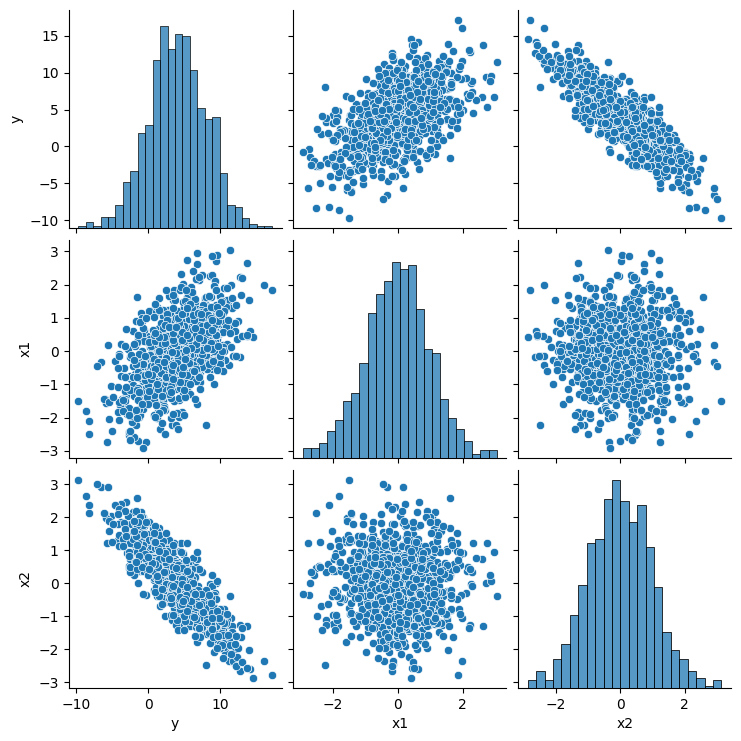

In [3]:
df = pd.DataFrame(torch.cat([y.reshape(-1, 1), X], dim=1), columns=["y", "x1", "x2"])
sns.pairplot(df)

### Data Splitting

The data is split into training and validation sets. The training set is used to train the model, and the validation set is used to evaluate its performance. This split helps in detecting overfitting and underfitting.

In [4]:
def train_test_split(X, y, train_size=0.8):
    # Shuffle the indices
    indices = torch.randperm(len(X)).tolist()

    # Calculate the number of samples in the training set
    train_size = int(train_size * len(X))

    # Slice the tensors to create training and validation sets
    X_train, y_train = X[indices[:train_size]], y[indices[:train_size]]
    X_val, y_val = X[indices[train_size:]], y[indices[train_size:]]

    return X_train, y_train, X_val, y_val

In [5]:
X_train, y_train, X_val, y_val = train_test_split(X, y, train_size=0.8)
train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=64, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=64, shuffle=False)

## Linear Regression from Scratch

### Single Batch Iteration

In [6]:
in_features = X_train.shape[1]
num_samples = X_train.shape[0]
batch_size = 512

# Initialize weights
w = torch.randn(in_features, 1, requires_grad=True)
b = torch.zeros(1, 1, requires_grad=True)

parameters = [w, b]
optimizer = SGDScratch(parameters, lr=0.1)

# Create a batch
X_batch = X_train[: batch_size]
y_batch = y_train[: batch_size]

In [7]:
# Zero gradients
optimizer.zero_grad()

# Forward pass (training)
y_pred = X_batch @ w + b

# Calculate Loss
def mse_loss(y_pred, y): 
    loss = torch.mean((y - y_pred) ** 2)
    return loss

loss = mse_loss(y_pred, y_batch)
# Backward pass (compute gradients)
loss.backward()

# Update parameters
optimizer.step()

In [8]:
loss

tensor(29.7084, grad_fn=<MeanBackward0>)

### Define Training Loop and Model

In [9]:
class LinearRegressionScratch(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.w = torch.randn(in_features, 1, requires_grad=True)
        self.b = torch.zeros(1, 1, requires_grad=True)

    def forward(self, X):
        y_pred = X @ self.w + self.b
        return y_pred
    
    def parameters(self):
        return [self.w, self.b]

In [10]:
class MSELossScratch(nn.Module):
    def __init__(self):
        super(MSELossScratch, self).__init__()

    def forward(self, y_pred, y_true):
        loss = torch.mean((y_pred - y_true) ** 2)
        return loss


### Training the Model

Epoch 1/15, Training Loss: 26.6505, Validation Loss: 23.2110
Epoch 2/15, Training Loss: 15.6553, Validation Loss: 13.8214
Epoch 3/15, Training Loss: 9.3709, Validation Loss: 8.1961
Epoch 4/15, Training Loss: 5.5708, Validation Loss: 4.8505
Epoch 5/15, Training Loss: 3.2538, Validation Loss: 2.8952
Epoch 6/15, Training Loss: 1.9464, Validation Loss: 1.7248
Epoch 7/15, Training Loss: 1.1467, Validation Loss: 1.0347
Epoch 8/15, Training Loss: 0.7019, Validation Loss: 0.6120
Epoch 9/15, Training Loss: 0.4068, Validation Loss: 0.3666
Epoch 10/15, Training Loss: 0.2441, Validation Loss: 0.2193
Epoch 11/15, Training Loss: 0.1465, Validation Loss: 0.1308
Epoch 12/15, Training Loss: 0.0868, Validation Loss: 0.0783
Epoch 13/15, Training Loss: 0.0518, Validation Loss: 0.0470
Epoch 14/15, Training Loss: 0.0309, Validation Loss: 0.0283
Epoch 15/15, Training Loss: 0.0184, Validation Loss: 0.0172


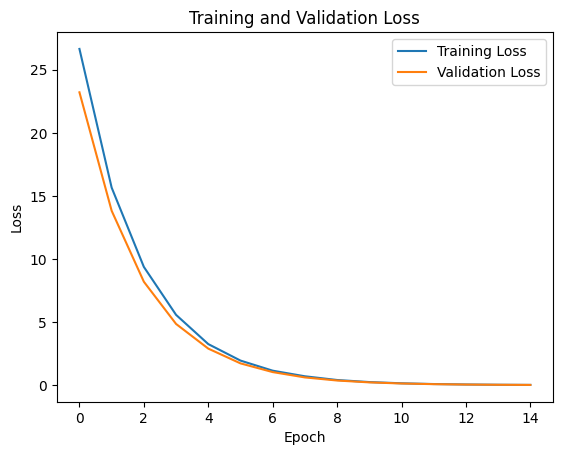

In [11]:
in_features = X_train.shape[1]
num_epochs = 15
learning_rate = 0.01

model = LinearRegressionScratch(in_features=in_features)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = MSELossScratch()
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=num_epochs)

## Regularized Linear Regression From Scratch

Regularization is a technique to reduce overfitting. In `RegularizedLinearRegressionModel`, we add a regularization term to the loss function:

$ \text{Total Loss} = \text{MSE Loss} + \frac{\lambda}{2} \sum_{i=1}^{d} w_i^2 $

- $\lambda$ is the regularization strength.
- The regularization term penalizes large weights, encouraging simpler models.

In [12]:
n, d = 20, 200
X = torch.randn(n, d)
noise = torch.randn(n, 1) * 0.01
w, b = torch.ones((d, 1)) * 0.01, 0.05

1
y = torch.matmul(X, w) + b + noise

In [13]:
X_train, y_train, X_val, y_val = train_test_split(X, y, train_size=0.2)
train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=64, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=64, shuffle=False)

We compare the performance of the regularized model with different $\lambda$ values to illustrate the effect of regularization.

In [14]:
class MSELossL2Scratch(nn.Module):
    def __init__(self, model, lambda_l2=0.01):
        super(MSELossL2Scratch, self).__init__()
        self.model = model
        self.lambda_l2 = lambda_l2

    def forward(self, y_pred, y_true):
        mse_loss = torch.mean((y_pred - y_true) ** 2)
        reg_loss = self.lambda_l2 * model.w.norm() ** 2 / 2
        total_loss = mse_loss + reg_loss
        return total_loss

Epoch 1/15, Training Loss: 151.5661, Validation Loss: 244.8795
Epoch 2/15, Training Loss: 8.0918, Validation Loss: 240.1942
Epoch 3/15, Training Loss: 0.9447, Validation Loss: 241.5317
Epoch 4/15, Training Loss: 0.1250, Validation Loss: 240.9222
Epoch 5/15, Training Loss: 0.0170, Validation Loss: 241.1306
Epoch 6/15, Training Loss: 0.0024, Validation Loss: 241.0480
Epoch 7/15, Training Loss: 0.0003, Validation Loss: 241.0778
Epoch 8/15, Training Loss: 0.0000, Validation Loss: 241.0664
Epoch 9/15, Training Loss: 0.0000, Validation Loss: 241.0706
Epoch 10/15, Training Loss: 0.0000, Validation Loss: 241.0690
Epoch 11/15, Training Loss: 0.0000, Validation Loss: 241.0696
Epoch 12/15, Training Loss: 0.0000, Validation Loss: 241.0694
Epoch 13/15, Training Loss: 0.0000, Validation Loss: 241.0694
Epoch 14/15, Training Loss: 0.0000, Validation Loss: 241.0694
Epoch 15/15, Training Loss: 0.0000, Validation Loss: 241.0694


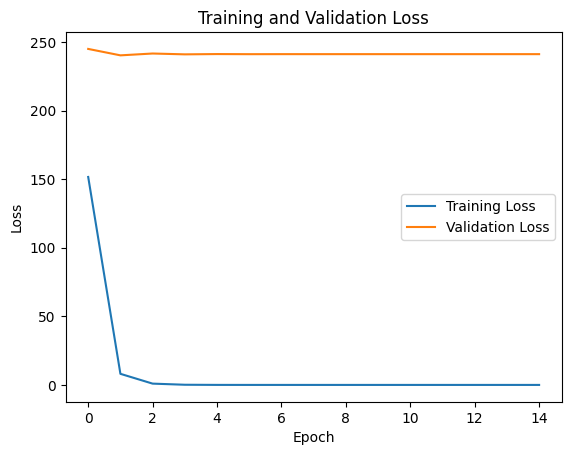

In [15]:
in_features = X_train.shape[1]
num_epochs = 15
learning_rate = 0.01
lambda_l2 = 0

model = LinearRegressionScratch(in_features=in_features)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = MSELossL2Scratch(model, lambda_l2=lambda_l2)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=num_epochs)

Epoch 1/15, Training Loss: 583.9941, Validation Loss: 571.0701
Epoch 2/15, Training Loss: 392.1589, Validation Loss: 515.3980
Epoch 3/15, Training Loss: 352.8147, Validation Loss: 465.5232
Epoch 4/15, Training Loss: 318.3652, Validation Loss: 420.1946
Epoch 5/15, Training Loss: 287.3205, Validation Loss: 379.3350
Epoch 6/15, Training Loss: 259.3065, Validation Loss: 342.4189
Epoch 7/15, Training Loss: 234.0242, Validation Loss: 309.1103
Epoch 8/15, Training Loss: 211.2071, Validation Loss: 279.0406
Epoch 9/15, Training Loss: 190.6147, Validation Loss: 251.9014
Epoch 10/15, Training Loss: 172.0300, Validation Loss: 227.4043
Epoch 11/15, Training Loss: 155.2573, Validation Loss: 205.2930
Epoch 12/15, Training Loss: 140.1200, Validation Loss: 185.3347
Epoch 13/15, Training Loss: 126.4586, Validation Loss: 167.3196
Epoch 14/15, Training Loss: 114.1291, Validation Loss: 151.0585
Epoch 15/15, Training Loss: 103.0018, Validation Loss: 136.3803


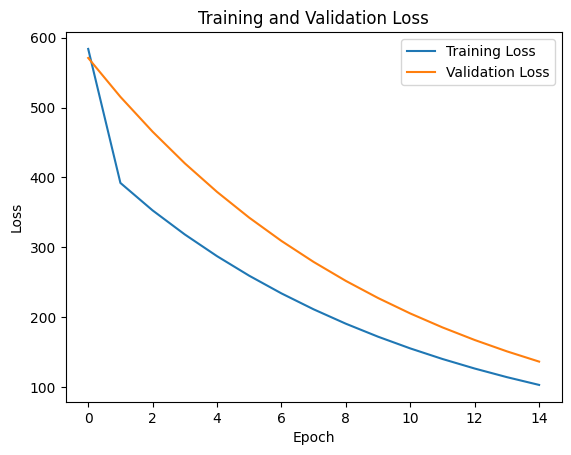

In [16]:
in_features = X_train.shape[1]
num_epochs = 15
learning_rate = 0.01
lambda_l2 = 5

model = LinearRegressionScratch(in_features=in_features)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = MSELossL2Scratch(model, lambda_l2=lambda_l2)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of Linear Regression with SGD

For a more concise implementation, we leverage PyTorch's built-in modules:

- **`nn.Linear`**: Defines a linear layer with weights and biases.
- **`optim.SGD`**: Stochastic Gradient Descent optimizer.
- **`nn.MSELoss`**: Mean Squared Error loss function.

These functions abstract away much of the manual work, allowing for a more streamlined and error-free implementation.

In [17]:
n = 1000
w = torch.tensor([2, -3.4]).reshape((-1, 1))
b = 4

X = torch.randn(n, len(w))
noise = torch.normal(mean=0, std=0.01, size=(n, 1))
y = X @ w + b + noise

Epoch 1/10, Training Loss: 24.2047, Validation Loss: 22.3942
Epoch 2/10, Training Loss: 14.2831, Validation Loss: 13.1561
Epoch 3/10, Training Loss: 8.4347, Validation Loss: 7.7034
Epoch 4/10, Training Loss: 4.8945, Validation Loss: 4.5362
Epoch 5/10, Training Loss: 2.8937, Validation Loss: 2.6634
Epoch 6/10, Training Loss: 1.6772, Validation Loss: 1.5779
Epoch 7/10, Training Loss: 0.9998, Validation Loss: 0.9298
Epoch 8/10, Training Loss: 0.5816, Validation Loss: 0.5528
Epoch 9/10, Training Loss: 0.3534, Validation Loss: 0.3236
Epoch 10/10, Training Loss: 0.2065, Validation Loss: 0.1898


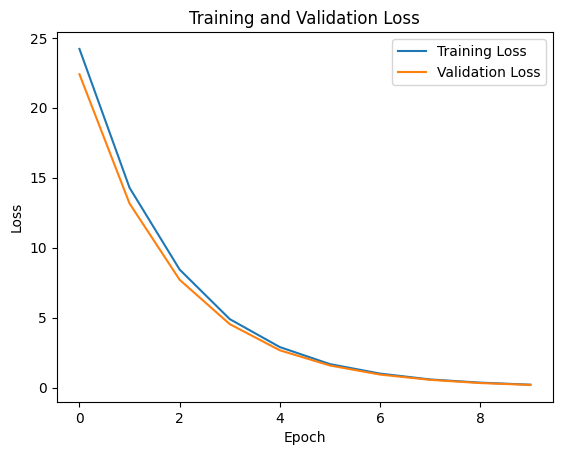

In [18]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)


model = LinearRegression(X.shape[1])

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=10)

In [19]:
model.linear.weight

Parameter containing:
tensor([[ 1.8759, -3.1151]], requires_grad=True)